In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Step 1: Load Data
data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
X, y = data.data, data.target
print(f"Dataset loaded with {len(X)} samples.")

Dataset loaded with 18846 samples.


In [ ]:
# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")


Training set size: 15076, Test set size: 3770


In [ ]:
# Step 3: Preprocessing and Feature Engineering
tfidf = TfidfVectorizer(stop_words='english', max_features=2000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# Step 4: Dimensionality Reduction for Visualization
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)

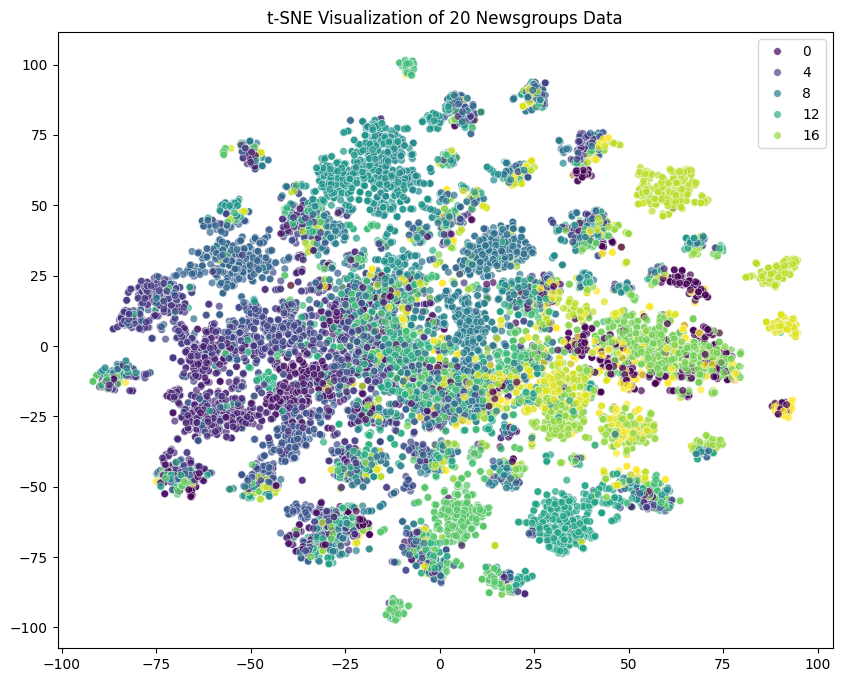

In [ ]:
# Visualize with t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train, palette="viridis", s=30, alpha=0.7)
plt.title("t-SNE Visualization of 20 Newsgroups Data")
plt.show()

In [ ]:
# Step 5: Model Training
nb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=1000, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)

In [ ]:
# Step 6: Ensemble Method - Stacking
estimators = [('nb', nb_model), ('lr', lr_model)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=nn_model)

In [ ]:
# Fit ensemble model
stacking_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


StackingClassifier(estimators=[('nb', MultinomialNB()),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42))],
                   final_estimator=MLPClassifier(hidden_layer_sizes=(128,),
                                                 max_iter=300,
                                                 random_state=42))

In [ ]:
# Step 7: Evaluation
y_pred = stacking_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=data.target_names))

Accuracy: 0.826790450928382
                          precision    recall  f1-score   support

             alt.atheism       0.83      0.83      0.83       151
           comp.graphics       0.65      0.73      0.69       202
 comp.os.ms-windows.misc       0.77      0.73      0.75       195
comp.sys.ibm.pc.hardware       0.59      0.60      0.59       183
   comp.sys.mac.hardware       0.78      0.73      0.75       205
          comp.windows.x       0.78      0.77      0.77       215
            misc.forsale       0.76      0.80      0.78       193
               rec.autos       0.88      0.83      0.85       196
         rec.motorcycles       0.89      0.92      0.91       168
      rec.sport.baseball       0.89      0.88      0.88       211
        rec.sport.hockey       0.91      0.90      0.91       198
               sci.crypt       0.94      0.94      0.94       201
         sci.electronics       0.77      0.76      0.77       202
                 sci.med       0.87      0.89  

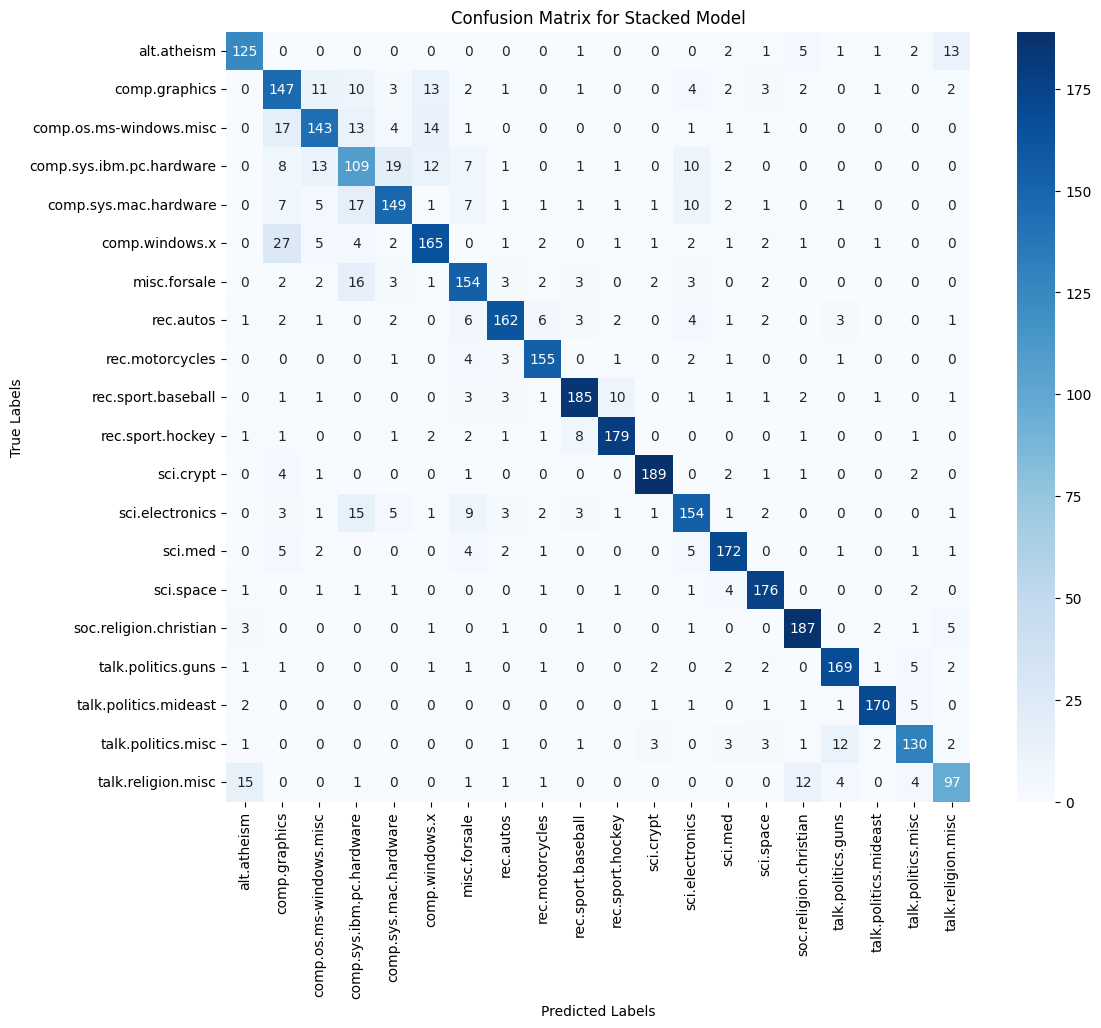

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Stacked Model")
plt.show()

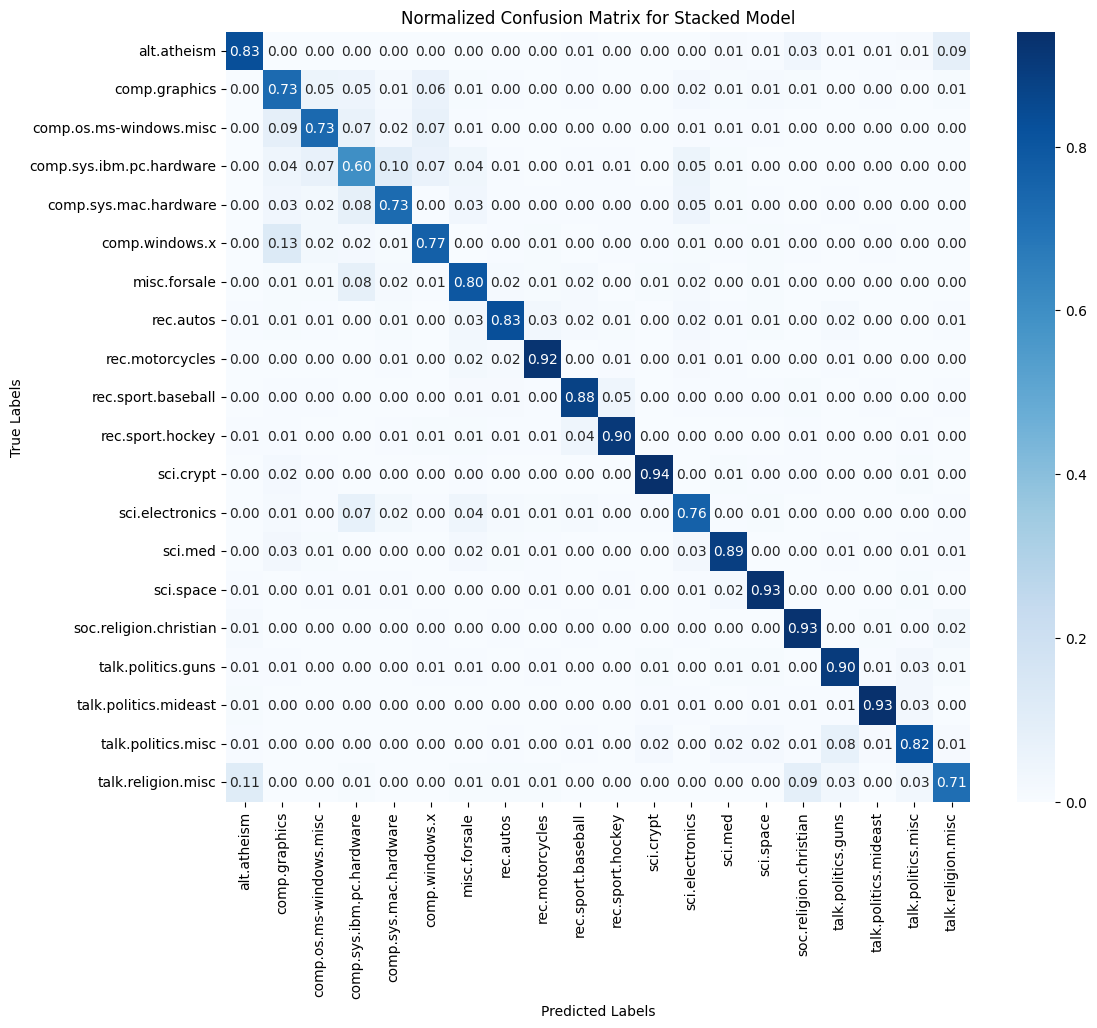

In [ ]:
# Normalized Confusion Matrix
norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix for Stacked Model")
plt.show()

In [ ]:
# Accuracy by Model Comparison
model_names = ['Naive Bayes', 'Logistic Regression', 'Stacking Model']
accuracies = [
    accuracy_score(y_test, nb_model.fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
    accuracy_score(y_test, lr_model.fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
    accuracy_score(y_test, y_pred)
]

<ipython-input-14-b0939571d9de>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")


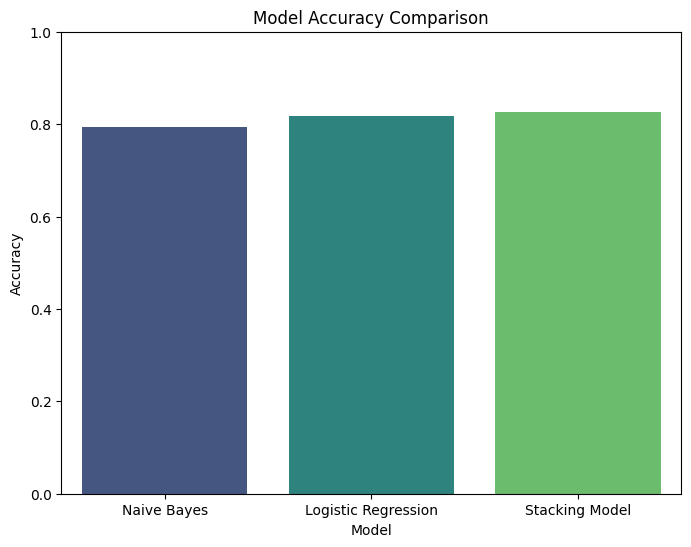

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Step 8: Feature Importance Visualization for Logistic Regression
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]
top_n = 20

In [ ]:
top_positive_coefficients = np.argsort(coefficients)[-top_n:]
top_negative_coefficients = np.argsort(coefficients)[:top_n]

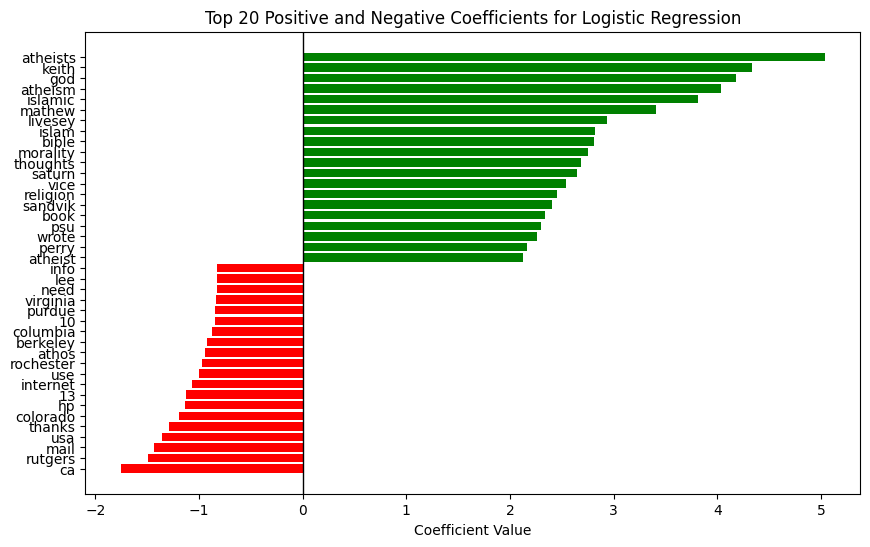

In [ ]:
# Combine the indices for positive and negative coefficients
combined_indices = np.concatenate([top_negative_coefficients, top_positive_coefficients])
combined_coefficients = np.concatenate([coefficients[top_negative_coefficients], coefficients[top_positive_coefficients]])
combined_feature_names = np.concatenate([feature_names[top_negative_coefficients], feature_names[top_positive_coefficients]])

plt.figure(figsize=(10, 6))
plt.barh(range(2 * top_n), combined_coefficients, color=['red'] * top_n + ['green'] * top_n)
plt.yticks(range(2 * top_n), combined_feature_names)
plt.title(f'Top {top_n} Positive and Negative Coefficients for Logistic Regression')
plt.xlabel('Coefficient Value')
plt.axvline(0, color='black', lw=1)  # Add a vertical line at x=0 for reference
plt.show()

In [ ]:
# Step 9: ROC Curve
y_prob = stacking_model.predict_proba(X_test_tfidf)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

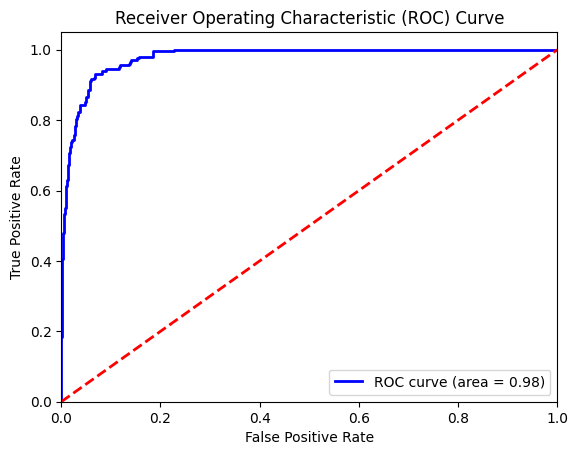

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()